In [3]:
import torch
import time
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [4]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Raw Sentence-BERT Embeddings

In [5]:
# Load Data
train_df = pd.read_csv("/kaggle/input/data-splits-20-06-2025/train_set.csv")
val_df = pd.read_csv("/kaggle/input/data-splits-20-06-2025/validation_set.csv")
test_df  = pd.read_csv("/kaggle/input/data-splits-20-06-2025/test_set.csv")

In [6]:
# Load SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Read titles and labels
titles_1 = test_df['title_1'].tolist()
titles_2 = test_df['title_2'].tolist()
labels = test_df['label'].values  

# Track inference time
start_time = time.time()

# Encode titles using SBERT 
embeddings1 = sbert_model.encode(titles_1, convert_to_tensor=True)
embeddings2 = sbert_model.encode(titles_2, convert_to_tensor=True)

# Compute cosine similarities
cosine_similarities = util.cos_sim(embeddings1, embeddings2).diagonal().cpu().numpy()

end_time = time.time()
inference_time = end_time - start_time

# Predict matches if similarity > threshold
threshold = 0.74
preds = (cosine_similarities > threshold).astype(int)

# Evaluate
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

print(f"Accuracy:   {accuracy:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1-score:   {f1:.4f}")
print(f"Inference Time: {inference_time:.2f} seconds")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Accuracy:   0.4802
Precision:  0.4858
Recall:     0.4802
F1-score:   0.4827
Inference Time: 1.06 seconds


In [8]:
# Create a dictionary with results
results_dict = {
    "Model": ["Raw Sentence-BERT"],
    "Accuracy": [accuracy],
    "F1-Score": [f1],
    "Inference Time (s)": [inference_time]
}

# Create a DataFrame
results_df = pd.DataFrame(results_dict)

# Optionally save to CSV
results_df.to_csv("raw_sentence-bert_inference_results.csv", index=False)

# Fine-Tuning Sentence-BERT Embeddings

In [9]:
import time
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Prepare training examples
train_examples = [
    InputExample(texts=[row['title_1'], row['title_2']], label=float(row['label']))
    for _, row in train_df.iterrows()
]

# Create DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)
train_loss = losses.CosineSimilarityLoss(model)

# Track training + validation time
start_train = time.time()

# Fine-tune
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=10,
    warmup_steps=100
)

end_train = time.time()
training_time = (end_train - start_train) / 60  # Convert to minutes

# Save the fine-tuned model
model.save("SentenceBERT-Fine-Tuned")

# ---------------------------
# Validation Evaluation (for best threshold)
# ---------------------------
emb1_val = model.encode(val_df['title_1'].tolist(), convert_to_tensor=True)
emb2_val = model.encode(val_df['title_2'].tolist(), convert_to_tensor=True)
labels_val = val_df['label'].values
cos_sim_val = util.cos_sim(emb1_val, emb2_val).diagonal().cpu().numpy()

# Find best threshold on validation set
best_f1 = 0
best_threshold = 0
f1_scores = []
for t in np.arange(0.3, 0.9, 0.01):
    preds_val = (cos_sim_val > t).astype(int)
    f1 = f1_score(labels_val, preds_val, average='weighted')
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# ---------------------------
# Test Set Inference & Evaluation
# ---------------------------
start_inference = time.time()

emb1_test = model.encode(test_df['title_1'].tolist(), convert_to_tensor=True)
emb2_test = model.encode(test_df['title_2'].tolist(), convert_to_tensor=True)
cos_sim_test = util.cos_sim(emb1_test, emb2_test).diagonal().cpu().numpy()

end_inference = time.time()
inference_time = (end_inference - start_inference) / 60  # Convert to minutes

# Predictions
labels_test = test_df['label'].values
preds_test = (cos_sim_test > best_threshold).astype(int)

# Evaluation metrics
acc_test = accuracy_score(labels_test, preds_test)
f1_test = f1_score(labels_test, preds_test, average='weighted')

# Save results to DataFrame
test_metrics = pd.DataFrame({
    "Model": ["Fine-Tuned Sentence-BERT"],
    "Accuracy": [acc_test],
    "F1-Score": [f1_test],
    "Best Threshold": [best_threshold],
    "Training Time (s)": [training_time],
    "Inference Time (s)": [inference_time]
})

# Optionally save
test_metrics.to_csv("fine-tuned_sentence-bert_metrics.csv", index=False)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.125100
1000,0.081300
1500,0.071000
2000,0.061500
2500,0.055000
3000,0.053800


Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


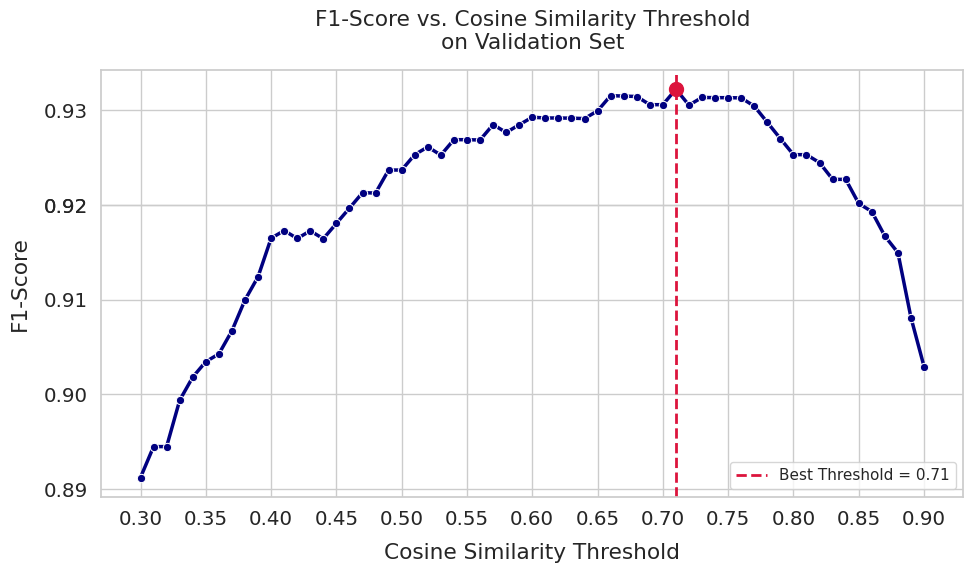

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fancy style
sns.set(style="whitegrid", context="notebook", font_scale=1.3)

# Thresholds and F1-scores (replace with your actual arrays)
thresholds = np.arange(0.3, 0.9, 0.01)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=thresholds, y=f1_scores, marker='o', linewidth=2.5, color='navy')

# Highlight best point
plt.axvline(best_threshold, color='crimson', linestyle='--', lw=2, label=f'Best Threshold = {best_threshold:.2f}')
plt.scatter(best_threshold, best_f1, color='crimson', s=100, zorder=5)

# Axis Labels and Title
plt.xlabel("Cosine Similarity Threshold", labelpad=10)
plt.ylabel("F1-Score", labelpad=10)
plt.title("F1-Score vs. Cosine Similarity Threshold\non Validation Set", pad=15)

# Customize ticks
plt.xticks(np.arange(0.3, 0.9, 0.05))
plt.yticks(np.round(np.linspace(min(f1_scores), max(f1_scores), 6), 2))

# Legend
plt.legend(loc='lower right', frameon=True, fontsize=11)

# Tight layout
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Example data for raw model
raw_cosines = cosine_similarities            # cosine similarities
raw_labels = labels_test             # ground-truth labels (0 or 1)
raw_preds = preds  # thresholded predictions
raw_f1 = f1_score(raw_labels, raw_preds)

# Example data for fine-tuned model
ft_cosines = cos_sim_test            # cosine similarities
ft_labels = labels_test             # same labels as above
ft_preds = preds_test
ft_f1 = f1_score(ft_labels, ft_preds)

# Create DataFrame for plotting
df_raw = pd.DataFrame({'cosine': raw_cosines, 'label': raw_labels, 'model': 'Raw SBERT'})
df_ft = pd.DataFrame({'cosine': ft_cosines, 'label': ft_labels, 'model': 'Fine-Tuned SBERT'})

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

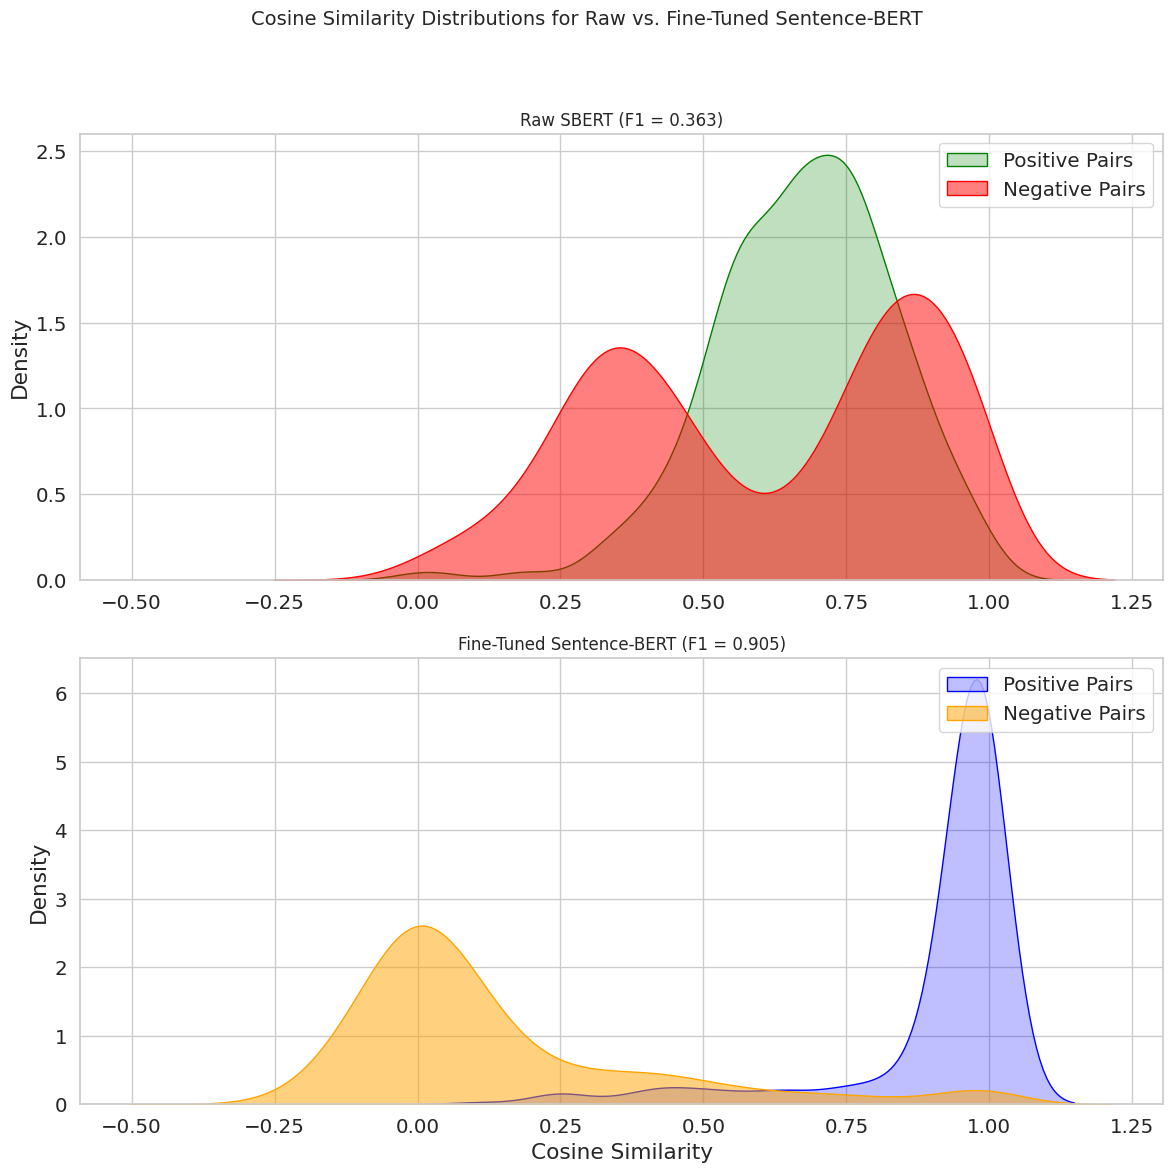

In [15]:
# Plot setup: 2 rows, 1 column
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Raw SBERT plot
sns.kdeplot(
    data=df_raw[df_raw["label"] == 1], x="cosine",
    ax=axes[0], label="Positive Pairs", color="green", fill=True
)
sns.kdeplot(
    data=df_raw[df_raw["label"] == 0], x="cosine",
    ax=axes[0], label="Negative Pairs", color="red", fill=True, alpha=0.5
)
axes[0].set_title(f"Raw SBERT (F1 = {raw_f1:.3f})", fontsize=12)
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].tick_params(labelbottom=True) 

# Fine-Tuned SBERT plot
sns.kdeplot(
    data=df_ft[df_ft["label"] == 1], x="cosine",
    ax=axes[1], label="Positive Pairs", color="blue", fill=True
)
sns.kdeplot(
    data=df_ft[df_ft["label"] == 0], x="cosine",
    ax=axes[1], label="Negative Pairs", color="orange", fill=True, alpha=0.5
)
axes[1].set_title(f"Fine-Tuned Sentence-BERT (F1 = {ft_f1:.3f})", fontsize=12)
axes[1].set_xlabel("Cosine Similarity")
axes[1].set_ylabel("Density")
axes[1].legend()

# Main title
plt.suptitle("Cosine Similarity Distributions for Raw vs. Fine-Tuned Sentence-BERT", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("figure_29_sbert_cosine_distributions_vertical.png", dpi=300)
plt.show()